# Stochastic depth

[Dropout](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) proved to be a working tool that improves the stability of a neural network. Essentially, dropout shuts down some neurons of a specific layer. Gao Huang, Yu Sun, Zhuang Liu What in the [article](https://arxiv.org/abs/1603.09382) _"Deep Networks with Stochastic Depth"_ went into further and attempted to shut down whole blocks of layers. 

In this notebook, we will investigate whether the stochastic depth improves accuracy of neural networks.

Pay attention to the [file](./resnet_with_stochastic_depth.py) if you want to know how the Stochastic ResNet is implemented.


In [1]:
import sys

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('../../..')
sys.path.append('../../utils')
import utils
from resnet_with_stochastic_depth import StochasticResNet
from batchflow import B,V,F
from batchflow.opensets import MNIST
from batchflow.models.tf import ResNet50

/home/anton/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In our expements we will work with MNIST dataset

In [2]:
dset = MNIST()

ExtractingExtracting ExtractingExtracting/tmp/train-labels-idx1-ubyte.gz   
/tmp/train-images-idx3-ubyte.gz/tmp/t10k-labels-idx1-ubyte.gz/tmp/t10k-images-idx3-ubyte.gz




Firstly, let us define the shape of inputs of our model, loss function and an optimizer:

In [3]:
ResNet_config = {
    'inputs': {'images': {'shape': (28, 28, 1)},
               'labels': {'classes': (10),
                          'transform': 'ohe',
                          'dtype': 'int64',
                          'name': 'targets'}},
    'input_block/inputs': 'images',
    'loss': 'softmax_cross_entropy',
    'optimizer': 'Adam',
    'output': dict(ops=['accuracy'])
}

Stochastic_config = {**ResNet_config}

Secondly, we create pipelines for train and test Simple ResNet model

In [8]:
res_train_ppl = (dset.train.p
                 .init_model('dynamic',
                             ResNet50,
                             'resnet',
                             config=ResNet_config)
                 .train_model('resnet',
                              feed_dict={'images': B('images'),
                                         'labels': B('labels')}))
res_test_ppl = (dset.test.p
                .init_variable('resacc', init_on_each_run=list)
                .import_model('resnet', res_train_ppl)
                .predict_model('resnet',
                               fetches='output_accuracy',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')},
                               save_to=V('resacc'), 
                               mode='a'))

The same thing for Stochastic ResNet model

In [9]:
stochastic_train_ppl = (dset.train.p
                        .init_model('dynamic',
                                    StochasticResNet,
                                    'stochastic',
                                    config=Stochastic_config)
                        .init_variable('stochasticacc', init_on_each_run=list)
                        .train_model('stochastic',
                                     feed_dict={'images': B('images'),
                                                'labels': B('labels')}))
stochastic_test_ppl = (dset.test.p
                       .init_variable('stochasticacc', init_on_each_run=list)
                       .import_model('stochastic', stochastic_train_ppl)
                       .predict_model('stochastic',
                                      fetches='output_accuracy',
                                      feed_dict={'images': B('images'),
                                                 'labels': B('labels')},
                                      save_to=V('stochasticacc'),
                                      mode='a'))

Let's train our models

In [17]:
for i in tqn(range(1000)):
    res_train_ppl.next_batch(400, n_epochs=None, shuffle=True)
    res_test_ppl.next_batch(400, n_epochs=None, shuffle=True)
    stochastic_train_ppl.next_batch(400, n_epochs=None, shuffle=True)
    stochastic_test_ppl.next_batch(400, n_epochs=None, shuffle=True)

Show test accuracy for all iterations

../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


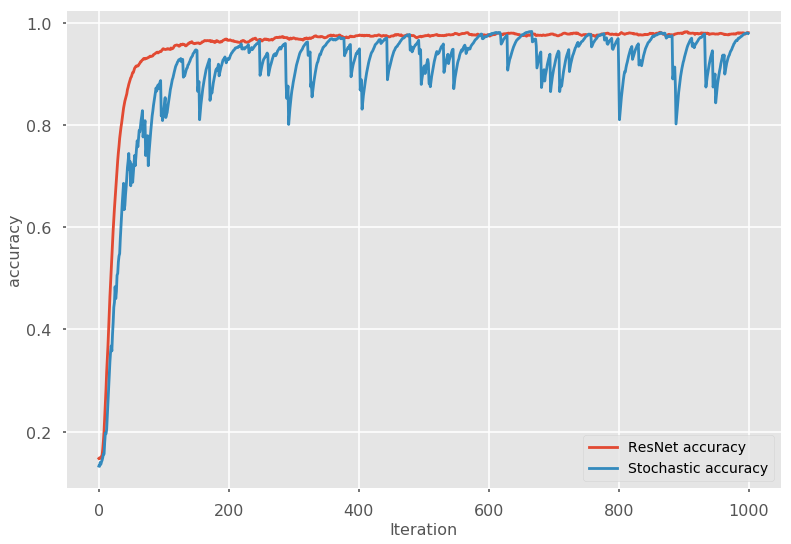

In [20]:
resnet_loss = res_test_ppl.get_variable('resacc')
stochastic_loss = stochastic_test_ppl.get_variable('stochasticacc')
utils.draw(resnet_loss, 'ResNet', stochastic_loss, 'Stochastic', window=20, type_data='accuracy')

It can be seen that the model with stochastic depth has a big variance, but reaches a similar quality with the usual model

### Conclusion:
* Our experement don't show any increase of accuracy for Stochastic ResNet.
* Dropping blocks from the network strongly affects the variance of the output.
* With the passage of time, this dispersion does not decrease.

### And what's next?
* In our experiment, we chose a certain shutdown threshold. You can choose another one to achieve better quality.
* If you still have not completed our tutorial, you can fix it right [now](./../../tutorial/00_description.ipynb)!
* Read and apply another experiments:
    * next [experiment](./../squeeze_and_excitation/squeeze_and_excitation.ipynb)
    * previous [experiment](./../zeroing_of_weights/zeroing_of_weights.ipynb)
    * return to the [table of contents](./../experiments_description.ipynb).
